In [1]:
# https://youtu.be/tepxdcepTbY
"""
@author: Sreenivas Bhattiprolu
Code tested on Tensorflow: 2.2.0
    Keras: 2.4.3
dataset: https://finance.yahoo.com/quote/GE/history/
Also try S&P: https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC
"""


'\n@author: Sreenivas Bhattiprolu\nCode tested on Tensorflow: 2.2.0\n    Keras: 2.4.3\ndataset: https://finance.yahoo.com/quote/GE/history/\nAlso try S&P: https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC\n'

In [2]:

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [3]:
#Read the csv file
df = pd.read_csv('GE.csv')
print(df.head()) #7 columns, including the Date. 


         Date       Open       High        Low      Close  Adj Close    Volume
0  2021-11-30  96.639999  97.430000  94.470001  94.989998  94.591263  11409400
1  2021-12-01  96.550003  96.889999  92.940002  93.000000  92.609612   8657100
2  2021-12-02  94.199997  95.779999  92.809998  95.230003  94.830254   6094600
3  2021-12-03  95.129997  95.349998  91.730003  92.769997  92.380577   8082800
4  2021-12-06  93.849998  96.889999  93.239998  96.010002  95.606979   6679900


In [4]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(5)) #Check last few dates. 

247   2022-11-22
248   2022-11-23
249   2022-11-25
250   2022-11-28
251   2022-11-29
Name: Date, dtype: datetime64[ns]


['Open', 'High', 'Low', 'Close', 'Adj Close']


<AxesSubplot:>

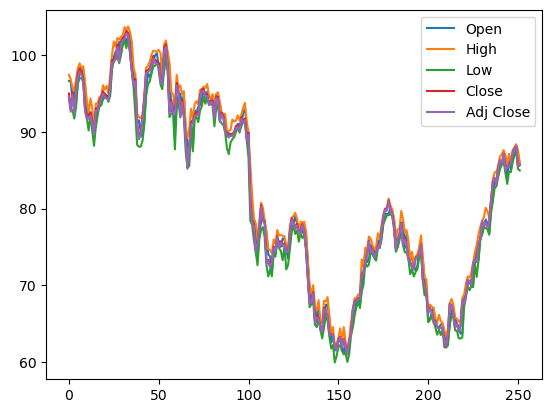

In [5]:
#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

df_for_plot=df_for_training.tail(5000)
df_for_plot.plot.line()

In [6]:
### ESTUDIA como funciona este tema del scaler... deberia ser entre 0 y 1, no?

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
df_for_training_scaled


array([[1.23587479, 1.20001955, 1.15791221, 1.10153851, 1.09116443],
       [1.22842055, 1.15553798, 1.03030857, 0.93622975, 0.92525269],
       [1.03377286, 1.06410381, 1.01946609, 1.12147568, 1.11117371],
       ...,
       [0.49538703, 0.4545425 , 0.56409593, 0.53251037, 0.55103883],
       [0.45397274, 0.38699662, 0.38144796, 0.31071414, 0.32749593],
       [0.33387153, 0.2519047 , 0.36476731, 0.32649765, 0.34340374]])

In [7]:



#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

In [8]:

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    ## en este caso Append añade un elemento que es un array de dos dimensiones.
    trainX.append( df_for_training_scaled[ i - n_past : i ,  0:df_for_training.shape[1]])
    #slicing: fila desde (i-n_past) hasta i///// Columna desde 0: 5 =>(df_for_training.shape[1])
    
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])  ##[17:18,0] un posicoin de la fila para la columna 0


In [9]:

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

"""
tenemos un array de 238 elementos en el que cada elemento es un array de 14x5
"""

trainX shape == (238, 14, 5).
trainY shape == (238, 1).


'\ntenemos un array de 238 elementos en el que cada elemento es un array de 14x5\n'

In [10]:
trainX[0][0][0]

1.2358747872347984

In [11]:

#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
14/14 [==============================] - 6s 51ms/step - loss: 0.6713 - val_loss: 0.0733
Epoch 2/5
14/14 [==============================] - 0s 15ms/step - loss: 0.2770 - val_l

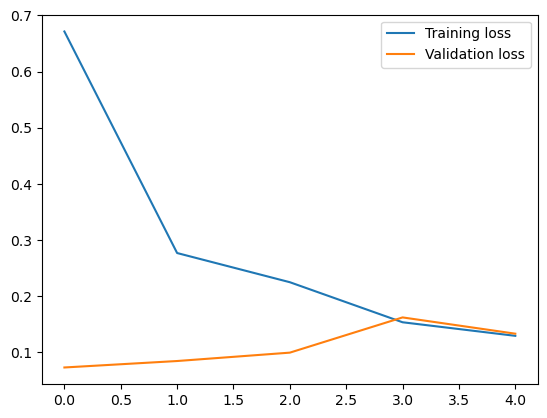

In [12]:


# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [13]:

#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction
                                                            # desde -n hasta el final. Cada elemento es un array bidimensional
#Pido una predcicion para un array de fechas, me devuelve la predicion para cada una

[Timestamp('2022-11-07 00:00:00', freq='C'), Timestamp('2022-11-08 00:00:00', freq='C'), Timestamp('2022-11-09 00:00:00', freq='C'), Timestamp('2022-11-10 00:00:00', freq='C'), Timestamp('2022-11-14 00:00:00', freq='C'), Timestamp('2022-11-15 00:00:00', freq='C'), Timestamp('2022-11-16 00:00:00', freq='C'), Timestamp('2022-11-17 00:00:00', freq='C'), Timestamp('2022-11-18 00:00:00', freq='C'), Timestamp('2022-11-21 00:00:00', freq='C'), Timestamp('2022-11-22 00:00:00', freq='C'), Timestamp('2022-11-23 00:00:00', freq='C'), Timestamp('2022-11-25 00:00:00', freq='C'), Timestamp('2022-11-28 00:00:00', freq='C'), Timestamp('2022-11-29 00:00:00', freq='C')]
1/1 [==============================] - 0s 418ms/step


In [14]:
#print (trainX[-2:])  # dos ultimos elementos. Cada elemento es un array de 15x5

print (prediction)

[[-0.4159675 ]
 [-0.35677287]
 [-0.29394993]
 [-0.21624382]
 [-0.13231595]
 [-0.04923456]
 [ 0.03031737]
 [ 0.08982208]
 [ 0.127836  ]
 [ 0.16257966]
 [ 0.18888336]
 [ 0.221728  ]
 [ 0.25887254]
 [ 0.2932581 ]
 [ 0.3068469 ]]


In [15]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [16]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

In [17]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [18]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

C:\Users\INNOVACION\AppData\Local\Temp\ipykernel_15872\2126096244.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


<AxesSubplot:xlabel='Date', ylabel='Open'>

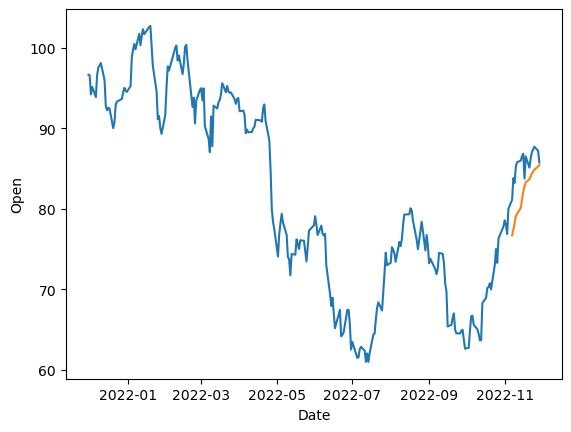

In [19]:
sns.lineplot(x=original['Date'], y=original['Open'])
sns.lineplot(x=df_forecast['Date'], y=df_forecast['Open'])

In [20]:

#from datetime import datetime












